# KAGGLE COMPETITION: Porto Seguro’s Safe Driver Prediction

## Predict if a driver will file an insurance claim next year.

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.externals import joblib

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report

import scikitplot as skplt

Displaying a maximum of five decimal places for better clarity.

In [2]:
pd.options.display.float_format = '{:.5f}'.format

### Load in data

In [3]:
df = pd.read_csv("train.csv")
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


Number of examples:

In [66]:
rows = len(df)
rows

595212

### Seperating features
The dataset includes numerical, categorical and binary features. The numerical features consist of ordinal and float values. Each feature type needs to be treated separately, so first of all we can create three lists of columns for the three feature types.

In [4]:
# separate col names into categories
cols = df.columns
num_feats, cat_feats, bin_feats = [], [], []

for col in cols:
    if col == 'id' or col == 'target':
        pass
    elif '_cat' in col:
        cat_feats.append(col)
    elif '_bin' in col:
        bin_feats.append(col)
    else:
        num_feats.append(col)
        
print('--- Numerical features --- : ', '\n', num_feats, '\n')
print('--- Categorical features --- : ', '\n', cat_feats, '\n')
print('--- Binary features --- : ', '\n', bin_feats, '\n')

--- Numerical features --- :  
 ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14'] 

--- Categorical features --- :  
 ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'] 

--- Binary features --- :  
 ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin'] 



### Data cleansing
The next step is to check how many missing values there are for each feature type. As a general rule, I like to eliminate features where more than one half of the values are missing.

In [5]:
# Although it uses more memory, I prefer to create a new copy of the dataframe for each section
df_cleaned = df.copy()

# I will also create copies for the feature lists
num_feats_cleaned = num_feats.copy()
cat_feats_cleaned = cat_feats.copy()
bin_feats_cleaned = bin_feats.copy()

#### Numerical features
Let's check for missing values (-1) in the numerical feature columns.

In [6]:
# I would like to eliminate any columns that consist of more than one half missing values (-1)
num_many_missing = df_cleaned[num_feats_cleaned][df == -1].count() / len(df) > 0.50 # more than 50% missing values
num_many_missing = num_many_missing.index[num_many_missing == True].tolist()
print(num_many_missing)

[]


No columns were returned. 
We can also have a look at exactly how many are missing in the applicable columns.

In [9]:
counts = df_cleaned[num_feats_cleaned][df == -1].count()
cols_with_missing = counts[counts.values > 0]
print('Column  ', 'Missing count  ', 'Missing ratio')
for col, count in zip(cols_with_missing.index, cols_with_missing.values):
    print(col, '  ', count, '  ', '{:.3f}'.format(count / len(df)))

Column   Missing count   Missing ratio
ps_reg_03    107772    0.181
ps_car_11    5    0.000
ps_car_12    1    0.000
ps_car_14    42620    0.072


We can substitute the missing values with the applicable column mean. This will limit their impact on the results.

In [10]:
# The few missing values that remain will be substituted with the column mean
for col in num_feats_cleaned:
    df_cleaned[col][df_cleaned[col] == -1] = df_cleaned[col].mean()
# Check that no missing values remain
(df_cleaned[num_feats_cleaned] == -1).sum().sum()   # sums instances of true for each column and then sums across columns

/Users/george/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/george/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0

We can be satisfied that no missing values remain.

#### Categorical features
I would like to eliminate any columns that consist of more than one-half missing values (-1). If features contain a relatively small proportion of missing values, these values can be converted to dummy variables and may be a useful part of the analysis.


In [10]:
cat_many_missing = df_cleaned[cat_feats_cleaned][df == -1].count() / len(df) > 0.5
cat_many_missing = cat_many_missing.index[cat_many_missing == True].tolist()
print(cat_many_missing)

['ps_car_03_cat']


In [11]:
# We can also have a look exactly how many are missing in the applicable columns
counts = df_cleaned[cat_feats_cleaned][df == -1].count()
cols_with_missing = counts[counts.values > 0]
print('Column  ', 'Missing count  ', 'Missing ratio')
for col, count in zip(cols_with_missing.index, cols_with_missing.values):
    print(col, '  ', count, '  ', '{:.3f}'.format(count / len(df)))

Column   Missing count   Missing ratio
ps_ind_02_cat    216    0.000
ps_ind_04_cat    83    0.000
ps_ind_05_cat    5809    0.010
ps_car_01_cat    107    0.000
ps_car_02_cat    5    0.000
ps_car_03_cat    411231    0.691
ps_car_05_cat    266551    0.448
ps_car_07_cat    11489    0.019
ps_car_09_cat    569    0.001


Now I will remove the one column that I identified.

In [12]:
df_cleaned.drop(columns=cat_many_missing, inplace=True)

In [13]:
# The cat_feats list needs to be updated
for i in cat_many_missing: cat_feats_cleaned.remove(i)

Remaing missing values will be converted to dummy variables during the feature engineering stage.

#### Binary features
Let's now check for missing values among the binary features.

In [14]:
bin_many_missing = df_cleaned[bin_feats_cleaned][df == -1].count() / len(df) > 0.5
bin_many_missing = bin_many_missing.index[bin_many_missing == True].tolist()
print(bin_many_missing)

[]


We can be sure that there are no features with more than half of there values missing. Let's just make sure that no values at all are missing for the binary features.

In [15]:
# Lets check for missing values, in case any exist
counts = df_cleaned[bin_feats_cleaned][df == -1].count()
cols_with_missing = counts[counts.values > 0]
cols_with_missing

Series([], dtype: int64)

### Exploratory data analysis
In this section, I will first explore the correlation between numerical features and then I will explore the correlation between each feature and the target variable.

#### Numerical features of float type

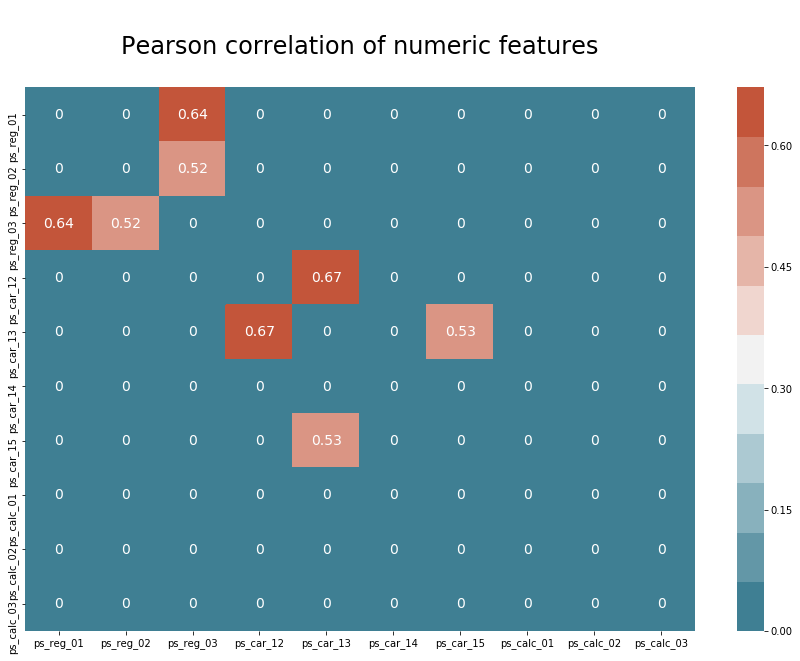

In [27]:
# First of all, we only want to select float values
df_float = df_cleaned.select_dtypes(['float64'])
df_corr = df_float.corr().abs()
# Setting a filter for values of 1 or less than 0.5
filter = (df_corr == 1) | (df_corr < 0.5)
# We can filter out values by setting them to 0
df_corr[filter] = 0
df_corr

f, ax = plt.subplots(figsize=(15, 10))
plt.title("\nPearson correlation of numeric features\n", size=24)
sns.heatmap(df_corr, annot=True, annot_kws={'size': 14},
            cmap=sns.diverging_palette(220, 20, n=11))

We can see that there are strong correlations between four pairs of features.

Let's look at pair plots of the strongly correlated variables. This way we can gain insight into the linear correlations between the features.

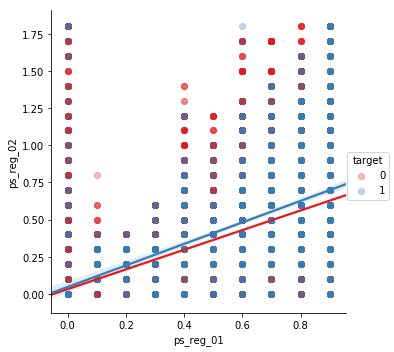

In [34]:
sns.lmplot(x='ps_reg_01', y='ps_reg_02', data=df_cleaned.sample(frac=0.1), hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

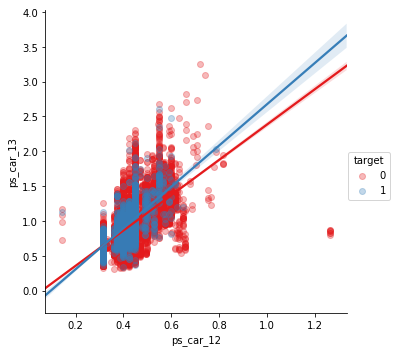

In [35]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=df_cleaned.sample(frac=0.1), hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

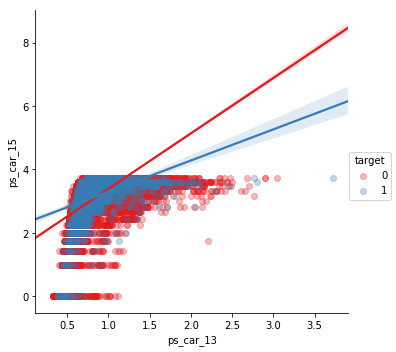

In [36]:
sns.lmplot(x='ps_car_13', y='ps_car_15', data=df_cleaned.sample(frac=0.1), hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### Numerical features of ordinal type

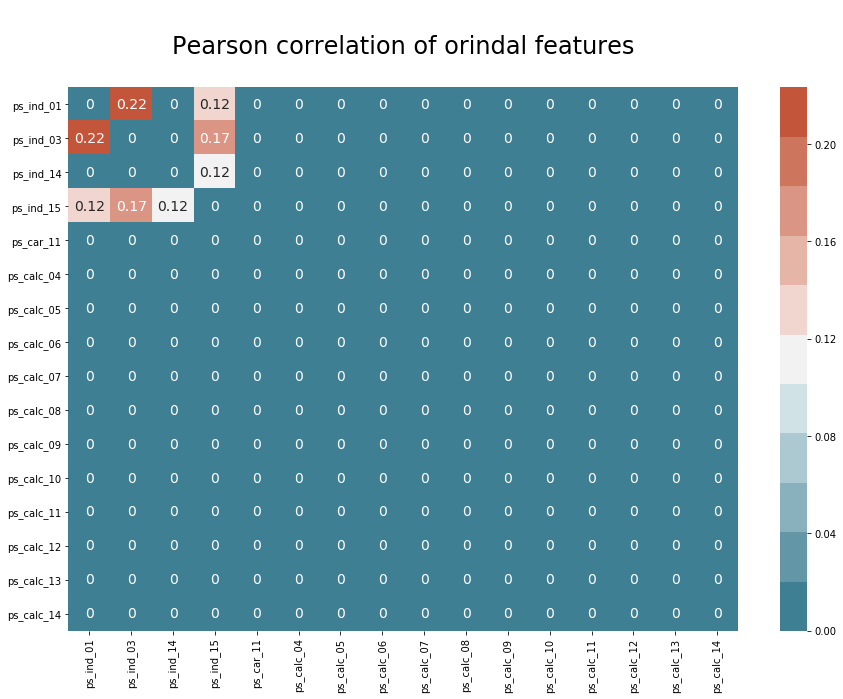

In [29]:
df_ordinal = df_cleaned[num_feats_cleaned].select_dtypes(include=['int'])
df_corr = df_ordinal.corr().abs()
filter = (df_corr == 1) | (df_corr < 0.1)
# We can filter out values by setting them to 0
df_corr[filter] = 0
df_corr

f, ax = plt.subplots(figsize=(15, 10))
plt.title("\nPearson correlation of orindal features\n", size=24)
sns.heatmap(df_corr, annot=True, annot_kws={'size': 14},
            cmap=sns.diverging_palette(220, 20, n=11))

The correlations are very small, so not worthy of consideration.

Let's now check the correlations between all numerical features and the target variables. We can use the **pointbiserialr** tool from scipy.stats to check the correlation between the numerical values of the features and the binary values of the target. The pointbiserialr method returns the correlation and the p-value. If the p-value is more than 0.05 for any given correlation, we cannot reject a null-hypothesis and should consider eliminating the feature, as it has a negligible impact on the target variable.

In [34]:
# check correlation between cols and target
num_weak_corr = []
for col in num_feats_cleaned:
    corr, p = pointbiserialr(df_cleaned[col], df_cleaned['target'])
    if p > .05:
        print(col.upper(), ' | Correlation: ', corr, '| P-value: ', p)
        num_weak_corr.append(col)

PS_CAR_11  | Correlation:  -0.00121335689622 | P-value:  0.349220144637
PS_CALC_01  | Correlation:  0.00178195465192 | P-value:  0.169200922734
PS_CALC_02  | Correlation:  0.00135968897833 | P-value:  0.294178988979
PS_CALC_03  | Correlation:  0.00190697359641 | P-value:  0.141229448762
PS_CALC_04  | Correlation:  3.27204551002e-05 | P-value:  0.979860521763
PS_CALC_05  | Correlation:  0.000770880136533 | P-value:  0.552022133573
PS_CALC_06  | Correlation:  8.18222597807e-05 | P-value:  0.949666387392
PS_CALC_07  | Correlation:  -0.000103476904853 | P-value:  0.936370675865
PS_CALC_08  | Correlation:  -0.00100585483842 | P-value:  0.43773988648
PS_CALC_09  | Correlation:  0.000718967584364 | P-value:  0.579111997695
PS_CALC_10  | Correlation:  0.00106083404448 | P-value:  0.413110667262
PS_CALC_11  | Correlation:  0.000371437394891 | P-value:  0.774446720276
PS_CALC_12  | Correlation:  -0.00113258539814 | P-value:  0.382233773313
PS_CALC_13  | Correlation:  -0.000446464531809 | P-value

#### Categorical features
For checking correlation between the categorical features and the target variable, we can create a crosstab table using Pandas and apply the **Chi-squared** tool to determine a p-value. Once again, if the p-value is more than 0.05, then we could reject that feature.

In [35]:
cat_weak_corr = []
for col in cat_feats_cleaned:
    crosstab = pd.crosstab( df['target'], df_cleaned[col],  rownames = ['target'] , colnames =['feature'])
    chi2, p, dof, ex = chi2_contingency(crosstab, correction=False)
    if p > 0.05:
        print(col.upper(), ' | Chi2: ', chi2, ' | p-value: ', p)
        cat_weak_corr.append(col)

PS_CAR_10_CAT  | Chi2:  0.648974774486  | p-value:  0.722897825327


It appears that all but one of the categorical features are worth keeping.

#### Binary features
We can do the same for the binary variables as we did for the categorical variables.

In [36]:
bin_weak_corr = []
for col in bin_feats_cleaned:
    crosstab = pd.crosstab( df['target'], df_cleaned[col],  rownames = ['target'] , colnames =['feature'])
    chi2, p, dof, ex = chi2_contingency(crosstab)
    if p > 0.05:
        print(col.upper(), ' | Chi2: ', chi2, ' | p-value: ', p)
        bin_weak_corr.append(col)

PS_IND_10_BIN  | Chi2:  1.49083915207  | p-value:  0.222086306306
PS_IND_11_BIN  | Chi2:  2.19212980726  | p-value:  0.138717387178
PS_IND_13_BIN  | Chi2:  3.18877595278  | p-value:  0.0741455110366
PS_CALC_15_BIN  | Chi2:  0.135285302885  | p-value:  0.713013790073
PS_CALC_16_BIN  | Chi2:  0.224798128543  | p-value:  0.635408055174
PS_CALC_17_BIN  | Chi2:  0.01544956754  | p-value:  0.901080685209
PS_CALC_18_BIN  | Chi2:  0.17519257769  | p-value:  0.675537637115
PS_CALC_19_BIN  | Chi2:  1.79054056273  | p-value:  0.180860314623
PS_CALC_20_BIN  | Chi2:  0.668511486963  | p-value:  0.413571052218


#### Using classification tools
Another approach is to use a classication tool - such as random forest - to determine the importance of each feature. We can achieve this by fitting a model and then calling the feature_importances method.

In [44]:
# Sets up a classifier and fits a model to all features of the dataset
clf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
clf.fit(df_cleaned.drop(['id', 'target'],axis=1), df_cleaned['target'])
# We need a list of features as well
features = df_cleaned.drop(['id', 'target'],axis=1).columns.values
print("--- COMPLETE ---")

--- COMPLETE ---


In [ ]:
joblib.dump(clf, 'clf_model.pkl')

Using the following code from Anisotropic's kernal (https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial), we can use Plotly to create a nice horizontal bar chart for visualising the ranking of most important features.

In [45]:
x, y = (list(x) for x in zip(*sorted(zip(clf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = None,
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Ranking of most influential features',
     width = 900, height = 1500,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Feature selection

I would like to select only the features that have the greatest impact according to the graph above, with a combination of all features types.

In [54]:
feats_to_keep = ['ps_ind_06_bin',
                     'ps_car_15',
                     'ps_ind_07_bin',
                     'ps_car_12',
                     'ps_car_01_cat',
                     'ps_ind_15',
                     'ps_car_14',
                     'ps_car_04_cat',
                     'ps_car_07_cat',
                     'ps_ind_03',
                     'ps_reg_02',
                     'ps_ind_17_bin',
                     'ps_reg_03',
                     'ps_ind_05_cat',
                     'ps_car_13']

In [96]:
# create new dataframe with only selected features, target and id
df_select_feats = df_cleaned[['id', 'target'] + feats_to_keep]

# separate col names into categories
num_feats_to_keep, cat_feats_to_keep, bin_feats_to_keep = [], [], []

for col in feats_to_keep:
    if col == 'id' or col == 'target':
        pass
    elif '_cat' in col:
        cat_feats_to_keep.append(col)
    elif '_bin' in col:
        bin_feats_to_keep.append(col)
    else:
        num_feats_to_keep.append(col)
        
print('--- Numerical features --- : ', '\n', num_feats_to_keep, '\n')
print('--- Categorical features --- : ', '\n', cat_feats_to_keep, '\n')
print('--- Binary features --- : ', '\n', bin_feats_to_keep, '\n')

--- Numerical features --- :  
 ['ps_car_15', 'ps_car_12', 'ps_ind_15', 'ps_car_14', 'ps_ind_03', 'ps_reg_02', 'ps_reg_03', 'ps_car_13'] 

--- Categorical features --- :  
 ['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_07_cat', 'ps_ind_05_cat'] 

--- Binary features --- :  
 ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_17_bin'] 



In [49]:
# # Removing the features that have weak correlations
# df_select_features.drop(columns=num_weak_corr + cat_weak_corr + bin_weak_corr, inplace=True)

# # The columns lists need to be updated as well
# for i in num_weak_corr: num_feats_selected.remove(i)
# for i in cat_weak_corr: cat_feats_selected.remove(i)
# for i in bin_weak_corr: bin_feats_selected.remove(i)

### Feature engineering
We still need to deal with the categorical variables because they cannot read in as they are. We need to create dummy variables for each feature. This will greatly increase the number of features that we have, so I would like to minimize these features if I can.

In [97]:
df_engineered = df_select_feats.copy()

We can check how many categories there are for each feature. This way we know which features are going to result in the most additional features after converting them to dummy variables.

In [98]:
df_engineered[cat_feats_to_keep].nunique()

ps_car_01_cat    13
ps_car_04_cat    10
ps_car_07_cat     3
ps_ind_05_cat     8
dtype: int64

In [99]:
# convert cat feats to dummy variables (0s and 1s)
cat_dummy_df = pd.get_dummies(df_engineered[cat_feats_to_keep].astype(str))
# replacing original cat cols with new dummie cols
df_engineered = pd.concat([df_engineered, cat_dummy_df], axis=1).drop(columns=cat_feats_to_keep)

In [108]:
df_engineered.shape

(595212, 47)

### Class balancing
Before going into feature scaling, I would like to check out the ratio of ones to zeros in the target variable. The reason I want to do this is because I already know that there is a very large class imbalance. We would not expect half of the people who are insured to lodge a claim. 

In [101]:
df_engineered['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

Sure enough, there are many more zeros. We can either over-sample (duplicate the training examples corresponding to the ones) or under-sample (remove training examples corresponding to the zeros).

In [102]:
# number of zeros
num_zeros = (df_engineered['target'] == 0).sum()
# number of ones
num_ones = (df_engineered['target'] == 1).sum()
# difference in the number of zeros and ones
diff = num_zeros - num_ones
# ratios
ones_to_zeros = num_ones / num_zeros
zeros_to_ones = num_zeros / num_ones
print('Ratio of ones to zeros: ', ones_to_zeros * 100, ' %')

Ratio of ones to zeros:  3.78261885416  %


#### Sampling from examples with a target of zero
I would like to select a sample that makes up half of the original length of the dataset.

In [126]:
df_zeros = df_engineered[df_engineered['target'] == 0]
df_zeros_sample = df_zeros.sample(n=int(rows / 2), random_state=42)
df_zeros_sample.reset_index(inplace=True, drop=True)

In [127]:
df_zeros_sample.head()

,id,target,ps_ind_06_bin,ps_car_15,ps_ind_07_bin,ps_car_12,ps_ind_15,ps_car_14,ps_ind_03,ps_reg_02,...,ps_car_07_cat_0,ps_car_07_cat_1,ps_ind_05_cat_-1,ps_ind_05_cat_0,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6
0,465947,0,1,0.00000,0,0.62498,5,0.42249,3,0.20000,...,0,1,0,1,0,0,0,0,0,0
1,381915,0,0,3.74166,0,0.31623,6,0.28879,9,0.50000,...,0,1,0,1,0,0,0,0,0,0
2,1060494,0,1,3.46410,0,0.40000,8,0.40743,7,0.80000,...,0,1,0,1,0,0,0,0,0,0
3,469383,0,0,3.00000,1,0.37417,13,0.38210,8,0.40000,...,0,1,0,1,0,0,0,0,0,0
4,491496,0,1,3.74166,0,0.40000,12,0.30968,2,0.20000,...,0,1,0,1,0,0,0,0,0,0


#### Duplicating examples with a target of one
I will duplicate all of the examples corresponding to ones.

In [121]:
df_ones = df_engineered[df_engineered['target'] == 1]
# Adds duplicates of the ones set until half of the dataset is occupied
df_ones_dup = pd.DataFrame()
for i in range(int((rows / 2) / num_ones)):
    df_ones_dup = df_ones_dup.append(df_ones)

#### Combining examples into one dataset

In [128]:
df_rebalanced = pd.concat([df_zeros_sample, df_ones_dup])
df_rebalanced = df_rebalanced.sample(frac=1).reset_index(drop=True)

In [129]:
df_rebalanced.shape

(579628, 47)

The number of rows is similar to what we started with.

### Feature scaling
Scaling features tends to lead to a performance improvement with classification problems, so we will do it here.

In [130]:
df_scaled = df_rebalanced.copy()
df_scaled.drop(columns=['target', 'id'], inplace=True)
# Set up scaler and create a scaled input matrix
scaler = MinMaxScaler()
# MinMaxScalar outputs data as a numpy array (which is necessary for XGBoost)
X_scaled = scaler.fit_transform(df_scaled)

### Training and Evaluation
Now we can split the data up into train and test sets, fit classification models to the train set and finally try to classify examples from the test set and observe the resulting accuracy.


++++++++++++++ LogReg ++++++++++++++


--- Training model using LogReg ---
=== DONE ===


              precision    recall  f1-score   support

          0       0.59      0.67      0.62     59588
          1       0.59      0.50      0.54     56338

avg / total       0.59      0.59      0.58    115926
 



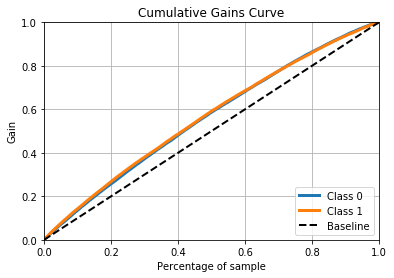



++++++++++++++ XGBoost ++++++++++++++


--- Training model using XGBoost ---
=== DONE ===


              precision    recall  f1-score   support

          0       0.60      0.67      0.63     59588
          1       0.60      0.52      0.56     56338

avg / total       0.60      0.60      0.60    115926
 



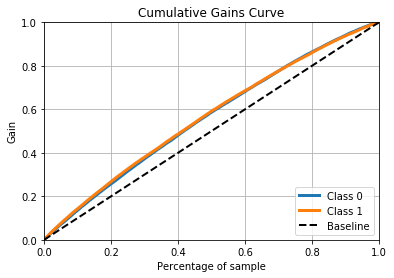

In [150]:
X = X_scaled
# y needs to be converted to an array
y = df_rebalanced['target'].as_matrix()
# split up the data and target values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

models = []
models.append(('LogReg', LogisticRegression()))
models.append(('XGBoost', XGBClassifier()))

for name, model in models:
    print('\n++++++++++++++ {} ++++++++++++++\n'.format(name))

    # Train model
    print('\n--- Training model using {} ---'.format(name))
    model.fit(X_train, y_train)
    print('=== DONE ===\n')
    
    # Save model
    joblib.dump(model, '{}_model_trained.pkl'.format(name))
    
    # Make predictions on the test-set
    y_pred = model.predict(X_test)

    # Classification report
    report = classification_report(y_test, y_pred)
    print('\n', report, '\n')

    # Plotting cumulative gains chart (lift curve)
    predicted_probas = LogReg_model.predict_proba(X_test)
    skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
    plt.show()
    
    print('======================================\n')